In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 7.0MB/s 


In [ ]:
cd drive/My\ Drive/Breast\ Cancer

/content/drive/My Drive/Breast Cancer


In [ ]:
import os
import pydicom
from pydicom.data import get_testdata_files
import numpy as np
import skimage.transform
import skimage.io as skio
import pandas as pd
import matplotlib.pyplot as plt


### Image Extraction Function:

In [ ]:
#This image retrieves all the DICOM images from the directory './Train_Images/CBIS-DDSM'
#Extract the image arrays and its patient ID
#Place the images in a new directory './Train_Images_npy'
def extract_image(folder_name, folder_npy):
    
    #Create a list of 
    filelist = []
    file_CC = []
    file_MLO = []
    boolean = []
    for root, dirs, files in os.walk(folder_name):
        for file in files:
        #append the file name to the list
            if file != '.DS_Store':
                filelist.append(os.path.join(root,file))

    print(filelist[0][26:42])
    
    for file_name in filelist:
        if file_name[34] == 'R':
            if file_name[26:42] in testset_items_flatten_CC:
                file_CC.append(file_name)
                boolean.append(file_name[26:42])
        else:
            if file_name[26:42] in testset_items_flatten_CC:
                file_CC.append(file_name)
                boolean.append(file_name[26:42])

    print(file_CC)
    
    
    #Given a DICOM Image img
    
    for img_name in file_CC:
        dicom_data = pydicom.dcmread(img_name)
        img_array = np.array(dicom_data.pixel_array)
        img_id = dicom_data.PatientID
        print(img_id)
        np.save(folder_npy + '/' + img_id, img_array)
        if os.path.exists(img_name):
              os.remove(img_name)
        else:
              print("The file does not exist")
       

In [ ]:
extract_image('./CBIS-DDSM', './Test_CC_npy')

P_01841_RIGHT_CC
['./CBIS-DDSM/Mass-Training_P_01841_RIGHT_CC/07-20-2016-DDSM-77254/1.000000-full mammogram images-87387/1-1.dcm', './CBIS-DDSM/Mass-Training_P_01878_RIGHT_CC/07-20-2016-DDSM-19551/1.000000-full mammogram images-89915/1-1.dcm', './CBIS-DDSM/Mass-Training_P_01850_RIGHT_CC/07-20-2016-DDSM-35189/1.000000-full mammogram images-59282/1-1.dcm', './CBIS-DDSM/Mass-Training_P_01886_RIGHT_CC/07-20-2016-DDSM-04229/1.000000-full mammogram images-25726/1-1.dcm', './CBIS-DDSM/Mass-Training_P_01826_RIGHT_CC/07-20-2016-DDSM-36179/1.000000-full mammogram images-67422/1-1.dcm', './CBIS-DDSM/Mass-Training_P_02079_RIGHT_CC/07-20-2016-DDSM-39196/1.000000-full mammogram images-39589/1-1.dcm', './CBIS-DDSM/Mass-Training_P_01831_RIGHT_CC/07-20-2016-DDSM-40009/1.000000-full mammogram images-71383/1-1.dcm', './CBIS-DDSM/Mass-Training_P_01860_RIGHT_CC/07-20-2016-DDSM-69131/1.000000-full mammogram images-98068/1-1.dcm', './CBIS-DDSM/Mass-Training_P_01848_RIGHT_CC/07-20-2016-DDSM-13247/1.000000-ful

### Image-Label Matching

In [ ]:
files = []
for (dirpath, dirnames, filenames) in os.walk('Test_CC_npy'):
  files.extend(filenames)

In [ ]:
files[0][14:22]

'P_00351_'

In [ ]:
image = None
label = 0
#len('Mass-Training_')
for filename in files :
  if not filename.endswith('.npz'):
    image = np.load(filename)
    id, dir = filename[14:21], filename[22]
    if dir == 'L':
      dir = 'LEFT'
    else:
      dir = 'RIGHT'
    label = trainset.loc[(trainset['patient_id'] == id) & 
                 (trainset['left or right breast'] == dir) & 
                 (trainset['image view'] == 'CC')]['breast_density'].tolist()    
    np.savez(filename[0:len(filename)-4], image ,label)


### Train ResNet Model

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
from torch.utils.data import Dataset

In [ ]:
img1 = np.load('/content/drive/My Drive/Breast Cancer/Train_CC_npy/Mass-Training_P_00001_LEFT_CC.npz')

In [ ]:
img1 = img1[img1.files[0]]

In [ ]:
im = np.divide(img1 ,(np.max(img1) - np.min(img1)))

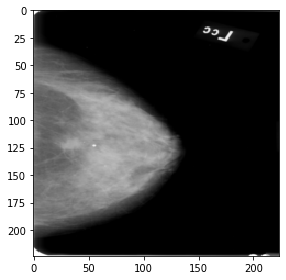

In [ ]:
skio.imshow(Transforms()(im).numpy().transpose([1,2,0]))

In [ ]:
class BreastCCDataset(Dataset):

    def __init__(self, split, transform = None):

        self.img_filenames = []
        self.labels = []
        self.root_dir = '/content/drive/My Drive/Breast Cancer/Train_CC_npy'
        self.transform = transform

        for subdir, dirs, files in os.walk(self.root_dir):
                for file in files:
                    if file.endswith(".npz"):
                        self.img_filenames.append(os.path.join(subdir, file))
        start, end = split[0], split[1]
        self.img_filenames = self.img_filenames[start:end]
    
    def __len__(self):
        return len(self.img_filenames)

    
    def __getitem__(self, index):
      data = np.load(self.img_filenames[index])
      items = data.files
      image_unscaled = np.array(data[items[0]])
      label = data[items[1]].astype(np.float32)
      if label[0] <= 1:
        label = np.array([0])
      else: 
        label = np.array([1])
      
      image = np.divide(image_unscaled, np.max(image_unscaled) - np.min(image_unscaled)).astype(np.float32)
      im = self.transform(image)
      return im, torch.from_numpy(label)
                

In [ ]:
import torchvision.transforms.functional as TF
from PIL import Image
class Transforms():

    def __init__(self):
      pass

    def __call__(self, image):
        
        #image_3channel = np.array([image] * 3)
        #_, h, w = image_3channel.shape
        #image_3channel = image_3channel.reshape((h,w,3))* 255 
        #print(image_3channel)
        #print(image.shape)
        image_PIL = Image.fromarray(image*255)#_3channel.astype(np.uint8))
        #print(image_PIL)
        image_gray = TF.to_grayscale(image_PIL, num_output_channels=3)
        image_resized = TF.resize(image_gray, (224,224))
        image = TF.to_tensor(image_resized)
        #print(image.shape)
        return image


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
train_dataset = BreastCCDataset(split = (0,116), transform = Transforms())
valid_dataset = BreastCCDataset(split = (116,146), transform = Transforms())

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 1, shuffle = True)

In [ ]:
inputs, labels = next(iter(train_loader))

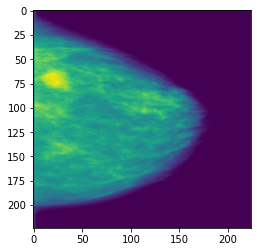

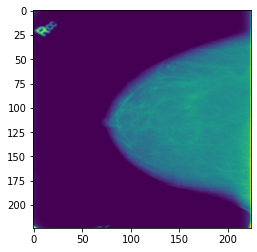

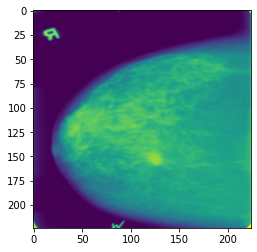

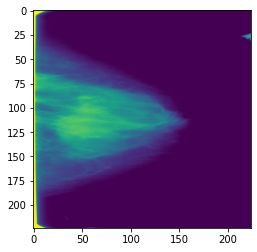

['cancer', 'no cancer', 'cancer', 'cancer']


In [ ]:
import matplotlib.pyplot as plt

def show_example(inputs):
    input_arr = inputs.numpy()
    for i in range(input_arr.shape[0]):
      
      im = input_arr[i].transpose((1,2,0)).reshape((224,224,3))
      plt.imshow(im[:,:,0])
      plt.pause(0.001)
      #print(im)


show_example(inputs)
classes = ['no cancer', 'cancer']
print([classes[i] for i in labels.numpy().flatten()])




In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)
resnet18 = resnet18.to(device)


criterion = nn.CrossEntropyLoss()#.to(device)
optimizer = optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
import time
import copy
from torchvision import datasets, models, transforms

In [ ]:
loss_min = np.inf
num_epochs = 25
start_time = time.time()

epoch_loss_train = []
epoch_acc_train = []
epoch_loss_valid = []
epoch_acc_valid = []

best_model_wts = copy.deepcopy(resnet18.state_dict())
best_correct = 0

for epoch in range(1, num_epochs + 1):
    print('>>>>>>>>>>> Training Epoch %d <<<<<<<<<<<<' %(epoch))

    loss_train = 0
    loss_valid = 0
    running_loss = 0
    running_correct_t = 0
    running_correct_v = 0

    resnet18.train()

    for step in range(1, len(train_loader)+1):

        images, labels = next(iter(train_loader))
        images = images.to(device)
        labels = labels.flatten().to(device)

        predictions = resnet18(images)

        optimizer.zero_grad()
        loss_train_step = criterion(predictions, labels)

        loss_train_step.backward()
        optimizer.step()
        
        #how the training loss is updating
        loss_train += loss_train_step.item()
        running_loss = loss_train/step 

        #how many correct predictions is the model making
        _, preds = torch.max(predictions, 1)
        running_correct_t += torch.sum(preds == labels.data).item()

        
        print('Train steps: %d/%d Loss: %.5f' % (step, len(train_loader), running_loss))


    #Epoch loss 
    epoch_loss_t = loss_train / len(train_loader)
    epoch_loss_train.append(epoch_loss_t)
    #Epoch Accuracy
    epoch_corr_t = running_correct_t / len(train_dataset)
    epoch_acc_train.append (epoch_corr_t) 
    exp_lr_scheduler.step()
    print('Train Epoch: %d/%d Epoch loss: %.5f Epoch Accuracy: %.4f' %(epoch, num_epochs, epoch_loss_t,epoch_corr_t))

    resnet18.eval()
    with torch.no_grad():

      for step in range(1, len(valid_loader) +1):
          images, labels = next(iter(valid_loader))
          images = images.to(device)
          labels = labels.flatten().to(device)
          
          predictions = resnet18(images)

          loss_valid_step = criterion(predictions,labels)
          loss_valid += loss_valid_step.item()
          running_loss = loss_valid/step

          _, preds = torch.max(predictions, 1)
          running_correct_v += torch.sum(preds == labels.data).item()

          print('Validation steps: %d/%d Loss: %.5f' % (step, len(valid_loader), running_loss))
    
    epoch_loss_v = loss_valid/len(valid_loader)
    epoch_loss_valid.append(epoch_loss_v)
    #Epoch Accuracy
    epoch_corr_v = running_correct_v / len(valid_dataset)
    epoch_acc_train.append (epoch_corr_v) 
    #exp_lr_scheduler.step()
    print('Validation Epoch: %d/%d Epoch loss: %.5f Epoch Accuracy: %.4f' %(epoch, num_epochs, epoch_loss_v, epoch_corr_v))

    if epoch_corr_v > best_correct:
        best_correct = epoch_corr_v
        best_model_wts = copy.deepcopy(resnet18.state_dict())


      



>>>>>>>>>>> Training Epoch 1 <<<<<<<<<<<<
Train steps: 1/29 Loss: 0.66276
Train steps: 2/29 Loss: 0.66967
Train steps: 3/29 Loss: 0.76622
Train steps: 4/29 Loss: 0.79603
Train steps: 5/29 Loss: 0.79039
Train steps: 6/29 Loss: 0.77004
Train steps: 7/29 Loss: 0.73499
Train steps: 8/29 Loss: 0.66531
Train steps: 9/29 Loss: 0.83464
Train steps: 10/29 Loss: 0.77397
Train steps: 11/29 Loss: 0.74860
Train steps: 12/29 Loss: 0.71184
Train steps: 13/29 Loss: 0.72125
Train steps: 14/29 Loss: 0.70563
Train steps: 15/29 Loss: 0.68552
Train steps: 16/29 Loss: 0.66601
Train steps: 17/29 Loss: 0.69060
Train steps: 18/29 Loss: 0.66677
Train steps: 19/29 Loss: 0.64522
Train steps: 20/29 Loss: 0.63745
Train steps: 21/29 Loss: 0.67451
Train steps: 22/29 Loss: 0.67366
Train steps: 23/29 Loss: 0.66282
Train steps: 24/29 Loss: 0.65780
Train steps: 25/29 Loss: 0.65597
Train steps: 26/29 Loss: 0.65507
Train steps: 27/29 Loss: 0.65063
Train steps: 28/29 Loss: 0.64275
Train steps: 29/29 Loss: 0.63692
Train Epoc

In [ ]:
torch.save(best_model_wts, '/content/drive/My Drive/Breast Cancer/best_model.pth')

### Test Data

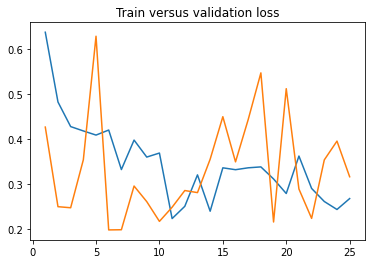

In [ ]:
plt.plot(np.arange(1,26),epoch_loss_train)
plt.plot(np.arange(1,26),epoch_loss_valid)
plt.title('Train versus validation loss')
plt.show()

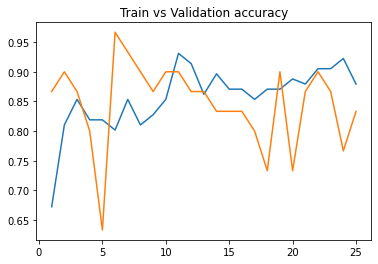

In [ ]:
plt.plot(np.arange(1,26),epoch_acc_train[::2])
plt.plot(np.arange(1,26),epoch_acc_train[1::2])
plt.title('Train vs Validation accuracy')
plt.show()

In [ ]:
files = []
for dirs, dir, file in os.walk('./'):
  for i in file:
    if i.endswith('.npz'):
      files.append(i)  

### Test the Model

In [ ]:
class BreastCCTestDataset(Dataset):

    def __init__(self, split, transform = None):

        self.img_filenames = []
        self.labels = []
        self.root_dir = '/content/drive/My Drive/Breast Cancer/Test_CC_npy'
        self.transform = transform

        for subdir, dirs, files in os.walk(self.root_dir):
                for file in files:
                    if file.endswith(".npz"):
                        self.img_filenames.append(os.path.join(subdir, file))
        start, end = split[0], split[1]
        self.img_filenames = self.img_filenames[start:end]
    
    def __len__(self):
        return len(self.img_filenames)

    
    def __getitem__(self, index):
      data = np.load(self.img_filenames[index])
      
      items = data.files
      image_unscaled = np.array(data[items[0]])
      #print(image_unscaled)
      label = data[items[1]].astype(np.float32)
      #print(label)
      if label[0] <= 1:
        label = np.array([0])
      else: 
        label = np.array([1])
      
      image = np.divide(image_unscaled, np.max(image_unscaled) - np.min(image_unscaled)).astype(np.float32)
      #print(image)
      im = self.transform(image)
      return im, torch.from_numpy(label)
                

In [ ]:
test_dataset = BreastCCTestDataset((0,46),transform = Transforms())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 46, shuffle = False)

In [ ]:
test_dataset[0]

(tensor([[[0.8588, 0.8431, 0.8235,  ..., 0.8353, 0.9922, 1.0000],
          [0.8275, 0.8039, 0.7765,  ..., 0.5137, 0.8392, 0.9961],
          [0.7490, 0.6784, 0.5961,  ..., 0.3137, 0.4824, 0.9098],
          ...,
          [0.4118, 0.1333, 0.0941,  ..., 0.1882, 0.4549, 0.8941],
          [0.4902, 0.1686, 0.1098,  ..., 0.2549, 0.7059, 0.9765],
          [0.6235, 0.2667, 0.1216,  ..., 0.5098, 0.9412, 1.0000]],
 
         [[0.8588, 0.8431, 0.8235,  ..., 0.8353, 0.9922, 1.0000],
          [0.8275, 0.8039, 0.7765,  ..., 0.5137, 0.8392, 0.9961],
          [0.7490, 0.6784, 0.5961,  ..., 0.3137, 0.4824, 0.9098],
          ...,
          [0.4118, 0.1333, 0.0941,  ..., 0.1882, 0.4549, 0.8941],
          [0.4902, 0.1686, 0.1098,  ..., 0.2549, 0.7059, 0.9765],
          [0.6235, 0.2667, 0.1216,  ..., 0.5098, 0.9412, 1.0000]],
 
         [[0.8588, 0.8431, 0.8235,  ..., 0.8353, 0.9922, 1.0000],
          [0.8275, 0.8039, 0.7765,  ..., 0.5137, 0.8392, 0.9961],
          [0.7490, 0.6784, 0.5961,  ...,

In [ ]:

best_network = resnet18.to(device)
best_network.load_state_dict(torch.load('/content/drive/My Drive/Breast Cancer/best_model.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
classes = ['not dense', 'dense']

In [ ]:
correct = 0
total = 0
best_network.eval()
y_true = None
y_pred = None

with torch.no_grad():
  for step in range(1, len(test_loader) +1):
      images, labels = next(iter(test_loader))
      images = images.to(device)
      labels = labels.flatten().to(device)
      
      outputs = best_network(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      y_true = labels.cpu().numpy()
      y_pred = predicted.cpu().numpy()
      y_output = outputs.cpu().numpy()
      
      #im = images.cpu().numpy()[0].transpose((1,2,0))
      #plt.imshow(im)
      #plt.pause(0.001)
      #print('True Label: ' + classes[labels.item()] + ' Predicated: ' + classes[predicted.item()])

print('Accuracy of the network on the 46 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 46 test images: 82 %


### Confusion Matrix

In [ ]:
TN = 0
TP = 0
FP = 0
FN = 0
#let dense-pred-dense be true negative
for i in range(len(y_true)):
  true = y_true[i]
  pred = y_pred[i]
  if true == 0 and pred == 0:
    TP += 1
  elif true == 1 and pred == 1:
    TN += 1
  elif true == 1 and pred == 0:
    FP += 1
  else:
    FN += 1

In [ ]:
confustion_mat = np.zeros((2,2))
confustion_mat[0][0] = TP/9
confustion_mat[1][1] = TN/37
confustion_mat[0][1] = FN/9
confustion_mat[1][0] = FP/37

In [ ]:
confustion_mat

array([[0.77777778, 0.22222222],
       [0.16216216, 0.83783784]])

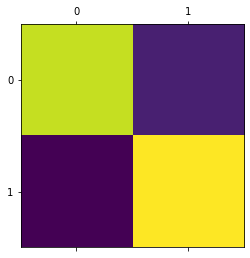

In [ ]:
plt.matshow(confustion_mat)

###ROC AUC Analysis:

In [ ]:
from  sklearn.metrics import roc_curve, auc

In [ ]:
y_output = np.amax(y_output, axis = 1)

In [ ]:
fpr, tpr, threshold = roc_curve(y_true, y_output, pos_label = 1)

In [ ]:
roc_auc = auc(fpr, tpr)

In [ ]:
roc_auc

0.5855855855855856

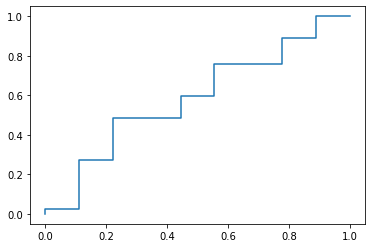

In [ ]:
plt.plot(fpr, tpr)

### An Example:

In [ ]:
dicom_data = pydicom.dcmread(filelist[0])
img_array = np.array(dicom_data.pixel_array)

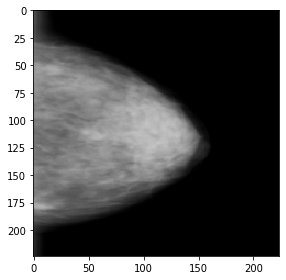

In [ ]:
skio.imshow(image_resize(img_array),(224,224))

### Dataset Analysis

In [ ]:
trainset = pd.read_csv("mass_case_description_train_set.csv")

In [ ]:
trainset.loc[(trainset['patient_id'] == 'P_00001') &
                 (trainset['left or right breast'] == 'LEFT') & 
                 (trainset['image view'] == 'CC')]['breast_density'].tolist()

[3]

In [ ]:
trainset.loc[(trainset['image view'] == 'CC') & trainset['breast_density'] < 3].sort_values(by = ['patient_id'], ascending = False).head(50)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
1317,P_02092,2,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,3,MALIGNANT,2,Mass-Training_P_02092_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_02092_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_02092_LEFT_MLO_1/1.3.6.1.4.1.9...
1316,P_02092,2,LEFT,CC,1,mass,IRREGULAR,SPICULATED,3,MALIGNANT,2,Mass-Training_P_02092_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...
1315,P_02079,2,RIGHT,MLO,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....
1314,P_02079,2,RIGHT,CC,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_CC/1.3.6.1.4.1.959...,Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...,Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...
1313,P_02033,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,4,Mass-Training_P_02033_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....
1312,P_02033,2,RIGHT,CC,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,4,Mass-Training_P_02033_RIGHT_CC/1.3.6.1.4.1.959...,Mass-Training_P_02033_RIGHT_CC_1/1.3.6.1.4.1.9...,Mass-Training_P_02033_RIGHT_CC_1/1.3.6.1.4.1.9...
1311,P_01983,2,LEFT,MLO,1,mass,OVAL,SPICULATED,3,MALIGNANT,5,Mass-Training_P_01983_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_01983_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_01983_LEFT_MLO_1/1.3.6.1.4.1.9...
1310,P_01981,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,5,Mass-Training_P_01981_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_01981_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_01981_RIGHT_MLO_1/1.3.6.1.4.1....
1309,P_01981,2,RIGHT,CC,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,5,Mass-Training_P_01981_RIGHT_CC/1.3.6.1.4.1.959...,Mass-Training_P_01981_RIGHT_CC_1/1.3.6.1.4.1.9...,Mass-Training_P_01981_RIGHT_CC_1/1.3.6.1.4.1.9...
1308,P_01946,2,RIGHT,MLO,1,mass,IRREGULAR,OBSCURED,3,MALIGNANT,3,Mass-Training_P_01946_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_01946_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_01946_RIGHT_MLO_1/1.3.6.1.4.1....


In [ ]:
trainset_ID_CC = []
trainset_ID_MLO = []
for i in range (4):    
    patient_id = trainset.loc[(trainset['breast_density']==i+1) & (trainset['image view']=='CC')].head(40)[['patient_id','left or right breast','breast_density']].to_numpy().tolist()
    trainset_ID_CC.append(patient_id)
    patient_id = trainset.loc[(trainset['breast_density']==i+1) & (trainset['image view']=='MLO')].head(40)[['patient_id','left or right breast','breast_density']].to_numpy().tolist()
    trainset_ID_MLO.append(patient_id)

In [ ]:
trainset_items_CC = []
item_breast_pair_CC = {}
for i in trainset_ID_CC:
    for j in i:
        item = j[0]+ '_'+j[1]+'_CC'
        trainset_items_CC.append(item)
        item_breast_pair_CC[item] = j[2]   

In [ ]:
trainset_items_flatten_CC = np.sort(np.array(trainset_items_CC).flatten())

In [ ]:
len(trainset_items_flatten_CC)

160

In [ ]:
testset_ID_CC = []
testset_ID_CC = trainset.loc[(trainset['image view'] == 'CC') & trainset['breast_density'] < 3].sort_values(by = ['patient_id'], ascending = False).head(50)

In [ ]:
testset_ID_CC = trainset.loc[(trainset['image view'] == 'CC') & trainset['breast_density'] < 3].sort_values(by = ['patient_id'], ascending = False).head(50)[['patient_id','left or right breast','breast_density']].to_numpy().tolist()

In [ ]:
testset_ID_CC 

[['P_02092', 'LEFT', 2],
 ['P_02092', 'LEFT', 2],
 ['P_02079', 'RIGHT', 2],
 ['P_02079', 'RIGHT', 2],
 ['P_02033', 'RIGHT', 2],
 ['P_02033', 'RIGHT', 2],
 ['P_01983', 'LEFT', 2],
 ['P_01981', 'RIGHT', 2],
 ['P_01981', 'RIGHT', 2],
 ['P_01946', 'RIGHT', 2],
 ['P_01946', 'RIGHT', 2],
 ['P_01908', 'LEFT', 2],
 ['P_01890', 'LEFT', 2],
 ['P_01889', 'RIGHT', 1],
 ['P_01889', 'RIGHT', 1],
 ['P_01888', 'RIGHT', 2],
 ['P_01887', 'LEFT', 2],
 ['P_01887', 'LEFT', 2],
 ['P_01886', 'RIGHT', 3],
 ['P_01883', 'LEFT', 2],
 ['P_01878', 'RIGHT', 2],
 ['P_01878', 'RIGHT', 2],
 ['P_01877', 'LEFT', 1],
 ['P_01877', 'LEFT', 1],
 ['P_01876', 'LEFT', 3],
 ['P_01876', 'LEFT', 3],
 ['P_01866', 'RIGHT', 2],
 ['P_01866', 'RIGHT', 2],
 ['P_01864', 'LEFT', 2],
 ['P_01860', 'RIGHT', 4],
 ['P_01853', 'LEFT', 2],
 ['P_01853', 'LEFT', 2],
 ['P_01850', 'RIGHT', 3],
 ['P_01850', 'RIGHT', 3],
 ['P_01849', 'RIGHT', 1],
 ['P_01849', 'RIGHT', 1],
 ['P_01848', 'RIGHT', 1],
 ['P_01848', 'RIGHT', 1],
 ['P_01844', 'RIGHT', 2],
 

In [ ]:
testset_items_CC = []
item_breast_pair_CC = {}
for i in testset_ID_CC:
    
        item = i[0]+ '_'+i[1]+'_CC'
        testset_items_CC.append(item)
        item_breast_pair_CC[item] = i[2]   

In [ ]:
testset_items_flatten_CC = np.sort(np.array(testset_items_CC).flatten())

In [ ]:
testset_items_flatten_CC

array(['P_01824_RIGHT_CC', 'P_01824_RIGHT_CC', 'P_01826_RIGHT_CC',
       'P_01826_RIGHT_CC', 'P_01829_LEFT_CC', 'P_01831_RIGHT_CC',
       'P_01831_RIGHT_CC', 'P_01832_RIGHT_CC', 'P_01840_RIGHT_CC',
       'P_01841_RIGHT_CC', 'P_01841_RIGHT_CC', 'P_01844_RIGHT_CC',
       'P_01848_RIGHT_CC', 'P_01848_RIGHT_CC', 'P_01849_RIGHT_CC',
       'P_01849_RIGHT_CC', 'P_01850_RIGHT_CC', 'P_01850_RIGHT_CC',
       'P_01853_LEFT_CC', 'P_01853_LEFT_CC', 'P_01860_RIGHT_CC',
       'P_01864_LEFT_CC', 'P_01866_RIGHT_CC', 'P_01866_RIGHT_CC',
       'P_01876_LEFT_CC', 'P_01876_LEFT_CC', 'P_01877_LEFT_CC',
       'P_01877_LEFT_CC', 'P_01878_RIGHT_CC', 'P_01878_RIGHT_CC',
       'P_01883_LEFT_CC', 'P_01886_RIGHT_CC', 'P_01887_LEFT_CC',
       'P_01887_LEFT_CC', 'P_01888_RIGHT_CC', 'P_01889_RIGHT_CC',
       'P_01889_RIGHT_CC', 'P_01890_LEFT_CC', 'P_01908_LEFT_CC',
       'P_01946_RIGHT_CC', 'P_01946_RIGHT_CC', 'P_01981_RIGHT_CC',
       'P_01981_RIGHT_CC', 'P_01983_LEFT_CC', 'P_02033_RIGHT_CC',
       'P

In [ ]:
item_breast_pair_CC

{'P_01824_RIGHT_CC': 1,
 'P_01826_RIGHT_CC': 1,
 'P_01829_LEFT_CC': 4,
 'P_01831_RIGHT_CC': 2,
 'P_01832_RIGHT_CC': 1,
 'P_01840_RIGHT_CC': 3,
 'P_01841_RIGHT_CC': 1,
 'P_01844_RIGHT_CC': 2,
 'P_01848_RIGHT_CC': 1,
 'P_01849_RIGHT_CC': 1,
 'P_01850_RIGHT_CC': 3,
 'P_01853_LEFT_CC': 2,
 'P_01860_RIGHT_CC': 4,
 'P_01864_LEFT_CC': 2,
 'P_01866_RIGHT_CC': 2,
 'P_01876_LEFT_CC': 3,
 'P_01877_LEFT_CC': 1,
 'P_01878_RIGHT_CC': 2,
 'P_01883_LEFT_CC': 2,
 'P_01886_RIGHT_CC': 3,
 'P_01887_LEFT_CC': 2,
 'P_01888_RIGHT_CC': 2,
 'P_01889_RIGHT_CC': 1,
 'P_01890_LEFT_CC': 2,
 'P_01908_LEFT_CC': 2,
 'P_01946_RIGHT_CC': 2,
 'P_01981_RIGHT_CC': 2,
 'P_01983_LEFT_CC': 2,
 'P_02033_RIGHT_CC': 2,
 'P_02079_RIGHT_CC': 2,
 'P_02092_LEFT_CC': 2}